/home/balasuriya/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/balasuriya/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Loss: 1.7616 Acc: 0.4719
Val Loss: 1.2163 Acc: 0.6094
Train Loss: 1.1899 Acc: 0.6369
Val Loss: 0.7471 Acc: 0.7403
Accuracy of the network on the test images: 73 %


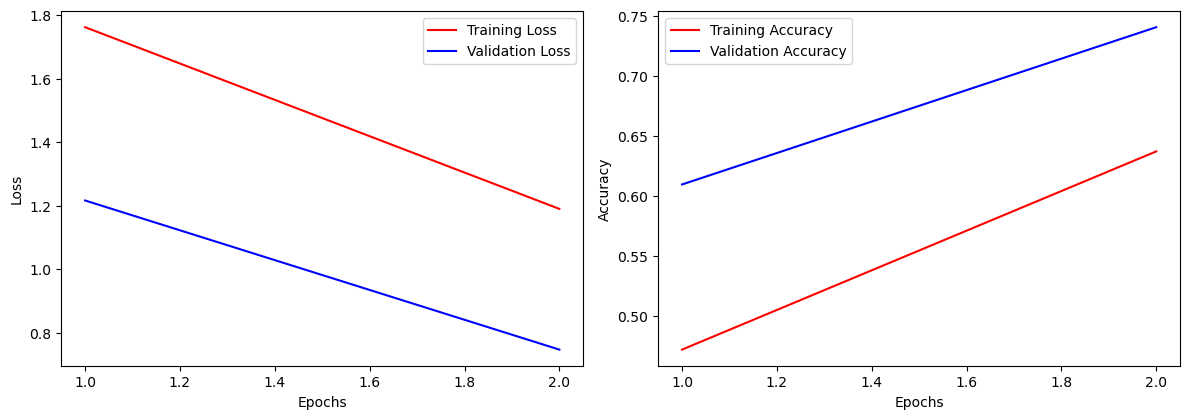

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define dataset directories
train_dir = '/home/balasuriya/Desktop/stuff/deeplearning.v1i.folder/train'
val_dir = '/home/balasuriya/Desktop/stuff/deeplearning.v1i.folder/valid'
test_dir = '/home/balasuriya/Desktop/stuff/deeplearning.v1i.folder/test'

# Define image transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

# Load datasets
image_datasets = {x: datasets.ImageFolder(eval(f'{x}_dir'), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# Load pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features

# Modify classifier with dropout regularization
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, len(image_datasets['train'].classes))
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Lists to store loss and accuracy values for plotting
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(2):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        correct = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                correct += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = correct.double() / len(image_datasets[phase])

        if phase == 'train':
            train_loss_list.append(epoch_loss)
            train_acc_list.append(epoch_acc)
        else:
            val_loss_list.append(epoch_loss)
            val_acc_list.append(epoch_acc)

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

# Plot the training and validation loss/accuracy
epochs = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss_list, 'r', label='Training Loss')
plt.plot(epochs, val_loss_list, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()



#since we can't plot tensors, we will change them to numpy arrays 
train_acc_list_np = [ele.cpu().numpy() for ele in train_acc_list]
val_acc_list_np = [ele.cpu().numpy() for ele in val_acc_list]

plt.subplot(2, 2, 2)
plt.plot(epochs, train_acc_list_np, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc_list_np, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=